<center><h1 style="color:blue">Email Classification by BERT</center>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<b>Dataset Loading from CSV file

In [9]:
import pandas as pd
df = pd.read_csv("spam.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

<b>Imbalance Dataset -> Downsampling

In [12]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [13]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [14]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [16]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [17]:
df_ham_downsampled.shape

(747, 2)

In [19]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
909,ham,WHITE FUDGE OREOS ARE IN STORES
3374,ham,Looks like you found something to do other tha...
4927,ham,"Oh yes, why is it like torture watching england?"
5231,ham,I realise you are a busy guy and i'm trying no...


In [20]:
df_balanced.shape

(1494, 2)

In [21]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

<b>Binary Column Creation

In [24]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...,...
909,ham,WHITE FUDGE OREOS ARE IN STORES,0
3374,ham,Looks like you found something to do other tha...,0
4927,ham,"Oh yes, why is it like torture watching england?",0
5231,ham,I realise you are a busy guy and i'm trying no...,0


<b>Test Train Split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [28]:
X_train.head(4)

2699                             FROM 88066 LOST £12 HELP
2216        Prabha..i'm soryda..realy..frm heart i'm sory
3571    Customer Loyalty Offer:The NEW Nokia6650 Mobil...
3527    HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEA...
Name: Message, dtype: object

<b>BERT

In [29]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [31]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [32]:
bert_model = hub.KerasLayer(encoder_url)

In [34]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess_model(sentences)
    return bert_model(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Mehedi, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327264, -0.8884572 , ..., -0.74748856,
        -0.75314724,  0.91964495],
       [-0.84204286, -0.6039915 , -0.9714014 , ..., -0.9139338 ,
        -0.76887876,  0.86640483]], dtype=float32)>

<b>Get embeding vectors for few sample words. Compare them using cosine similarity

In [35]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [40]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [41]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<b>Build Model</b><br>
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

<b>Functional

In [43]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess_model(text_input)
outputs = bert_model(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [45]:
len(X_train)

1120

In [46]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

<b>Train The Model

In [47]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 292s 8s/step - loss: 0.5780 - accuracy: 0.7411
Epoch 2/5
35/35 [==============================] - 290s 8s/step - loss: 0.4801 - accuracy: 0.8268
Epoch 3/5
35/35 [==============================] - 287s 8s/step - loss: 0.4144 - accuracy: 0.8527
Epoch 4/5
35/35 [==============================] - 285s 8s/step - loss: 0.3796 - accuracy: 0.8804
Epoch 5/5
35/35 [==============================] - 291s 8s/step - loss: 0.3517 - accuracy: 0.8884


<b>Evaluate

In [48]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 96s 8s/step - loss: 0.3230 - accuracy: 0.8984


[0.32299697399139404, 0.8983957171440125]

In [51]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 88s 7s/step


In [49]:
import numpy as np

In [52]:
y_predicted = np.where(y_predicted>0.5,1,0)
y_predicted

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89       187
           1       0.86      0.95      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



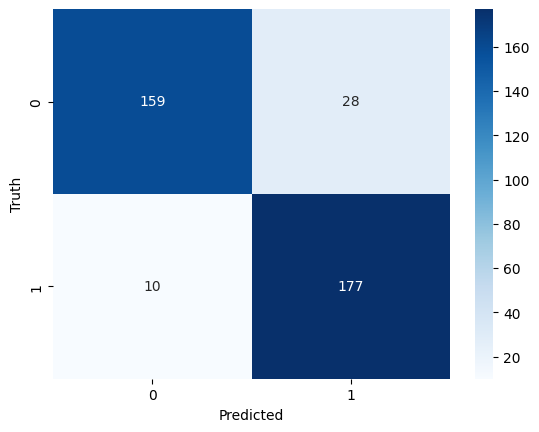

In [59]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Optional: 'cmap' for color
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()  # Show the plot

In [60]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7025676 ],
       [0.7830742 ],
       [0.78962636],
       [0.27429587],
       [0.18691353]], dtype=float32)

More that 0.5 means spam and less than means not spam